In [1]:
# !pip install -U git+https://github.com/albu/albumentations

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
 os.chdir("/content/drive/My Drive/Utils")

In [6]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
from models.NewModel import newModel
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam
from lr_finder import LRFinder
from lr_accuracy import LRAccuracy

  pip install torch-lr-finder -v --global-option="amp"


### Create model and display summary

In [7]:

model_obj = newModel()

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### Get data set object

In [8]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [9]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A
import cv2

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.PadIfNeeded(min_height=40, min_width=40),
                            A.RandomCrop(32,32),
                            A.HorizontalFlip(p=0.7),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [10]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [11]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=512)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

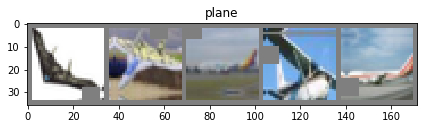

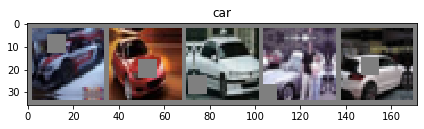

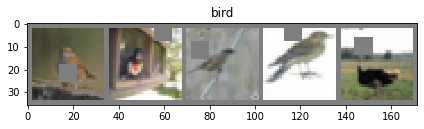

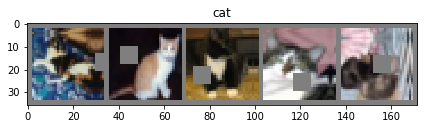

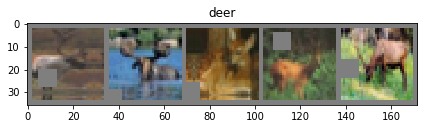

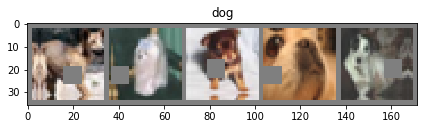

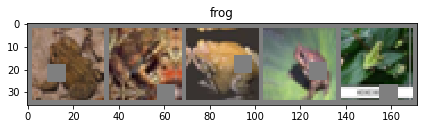

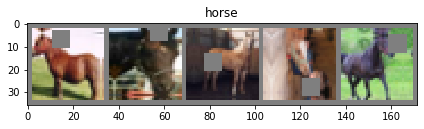

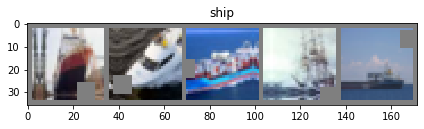

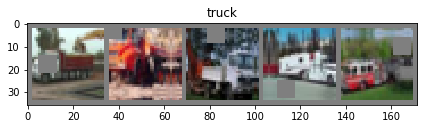

In [12]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Perform LR range test

In [13]:

criterion = nn.CrossEntropyLoss()
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.005, lr=1e-4, momentum=0.9) #SGD with l2 regulizer
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=10 * len(train_loader), step_mode="exp")




Learning rate search finished. See the graph with {finder_name}.plot()


### Plot Train accuracy vs Learning rate

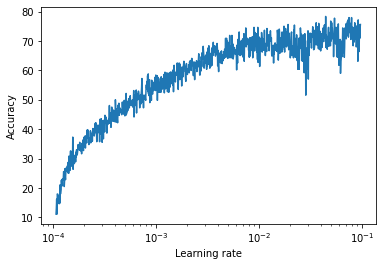

Best acc 78.3203125
Best LR:  0.044422151755141255


In [14]:


lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

### Plot Loss vs Learning rate

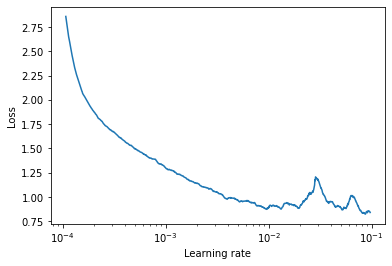

Best loss 0.8223999224014295
Best LR:  0.0868386318361836


In [15]:
lr_finder.plot(plot_case="loss")
best_loss_lr = lr_finder.get_best_lr(case="loss")

### Reset model to initial state

In [16]:
lr_finder.reset()


### Run the model

In [17]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR


optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9,weight_decay=0.005 ) 
scheduler = OneCycleLR(optimizer, max_lr = best_lr, total_steps=None, epochs=24, steps_per_epoch=len(train_loader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.9, max_momentum=0.95, div_factor=10,final_div_factor =1)
EPOCHS = 25


train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()
requires_misclassified = False

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    
    train_obj.train(model, device, train_loader, optimizer, criterion,scheduler = scheduler)
    if epoch == (EPOCHS - 1):
      requires_misclassified = True 
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=requires_misclassified)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: 0.004442215175514125


Train Set: Train Loss=1.2823292016983032 Batch_id=97 Accuracy=42.14: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 4840/10000 (48.40%)

EPOCH: 2
LR: 0.014442709797049098


Train Set: Train Loss=1.0982664823532104 Batch_id=97 Accuracy=60.22: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5978/10000 (59.78%)

EPOCH: 3
LR: 0.024443204418584073


Train Set: Train Loss=0.7881934642791748 Batch_id=97 Accuracy=69.56: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6811/10000 (68.11%)

EPOCH: 4
LR: 0.03444369904011905


Train Set: Train Loss=0.7420783638954163 Batch_id=97 Accuracy=73.90: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7314/10000 (73.14%)

EPOCH: 5
LR: 0.04441774403986065


Train Set: Train Loss=0.5711380839347839 Batch_id=97 Accuracy=78.12: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7425/10000 (74.25%)

EPOCH: 6
LR: 0.04241794729218022


Train Set: Train Loss=0.48522481322288513 Batch_id=97 Accuracy=81.74: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8069/10000 (80.69%)

EPOCH: 7
LR: 0.0404181505444998


Train Set: Train Loss=0.5260120630264282 Batch_id=97 Accuracy=84.17: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8424/10000 (84.24%)

EPOCH: 8
LR: 0.03841835379681937


Train Set: Train Loss=0.349273681640625 Batch_id=97 Accuracy=85.49: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8064/10000 (80.64%)

EPOCH: 9
LR: 0.03641855704913894


Train Set: Train Loss=0.3960370421409607 Batch_id=97 Accuracy=86.91: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8323/10000 (83.23%)

EPOCH: 10
LR: 0.03441876030145851


Train Set: Train Loss=0.38247931003570557 Batch_id=97 Accuracy=87.86: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8541/10000 (85.41%)

EPOCH: 11
LR: 0.03241896355377808


Train Set: Train Loss=0.47195562720298767 Batch_id=97 Accuracy=88.66: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8641/10000 (86.41%)

EPOCH: 12
LR: 0.03041916680609765


Train Set: Train Loss=0.3308948576450348 Batch_id=97 Accuracy=89.56: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8428/10000 (84.28%)

EPOCH: 13
LR: 0.028419370058417225


Train Set: Train Loss=0.2743765711784363 Batch_id=97 Accuracy=90.01: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8700/10000 (87.00%)

EPOCH: 14
LR: 0.026419573310736796


Train Set: Train Loss=0.2806277275085449 Batch_id=97 Accuracy=90.78: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8603/10000 (86.03%)

EPOCH: 15
LR: 0.02441977656305637


Train Set: Train Loss=0.21925194561481476 Batch_id=97 Accuracy=91.18: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8486/10000 (84.86%)

EPOCH: 16
LR: 0.02241997981537594


Train Set: Train Loss=0.2525993287563324 Batch_id=97 Accuracy=92.02: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8650/10000 (86.50%)

EPOCH: 17
LR: 0.02042018306769551


Train Set: Train Loss=0.27843594551086426 Batch_id=97 Accuracy=92.63: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8647/10000 (86.47%)

EPOCH: 18
LR: 0.01842038632001508


Train Set: Train Loss=0.1735910177230835 Batch_id=97 Accuracy=93.11: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8771/10000 (87.71%)

EPOCH: 19
LR: 0.016420589572334655


Train Set: Train Loss=0.20660275220870972 Batch_id=97 Accuracy=93.98: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8961/10000 (89.61%)

EPOCH: 20
LR: 0.014420792824654222


Train Set: Train Loss=0.1446266919374466 Batch_id=97 Accuracy=94.53: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9002/10000 (90.02%)

EPOCH: 21
LR: 0.012420996076973792


Train Set: Train Loss=0.1383577585220337 Batch_id=97 Accuracy=95.57: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9057/10000 (90.57%)

EPOCH: 22
LR: 0.010421199329293362


Train Set: Train Loss=0.1615019142627716 Batch_id=97 Accuracy=96.23: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9151/10000 (91.51%)

EPOCH: 23
LR: 0.008421402581612933


Train Set: Train Loss=0.09848032891750336 Batch_id=97 Accuracy=96.89: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9180/10000 (91.80%)

EPOCH: 24
LR: 0.006421605833932503


Train Set: Train Loss=0.07434281706809998 Batch_id=97 Accuracy=97.63: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]



Test set: Average loss: 0.0004, Accuracy: 9318/10000 (93.18%)

Maximum Training Accuracy =  97.63
Maximum Testing Accuracy =  93.18


### Display graphs

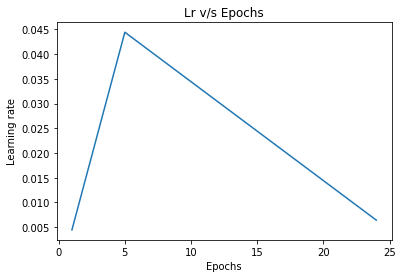

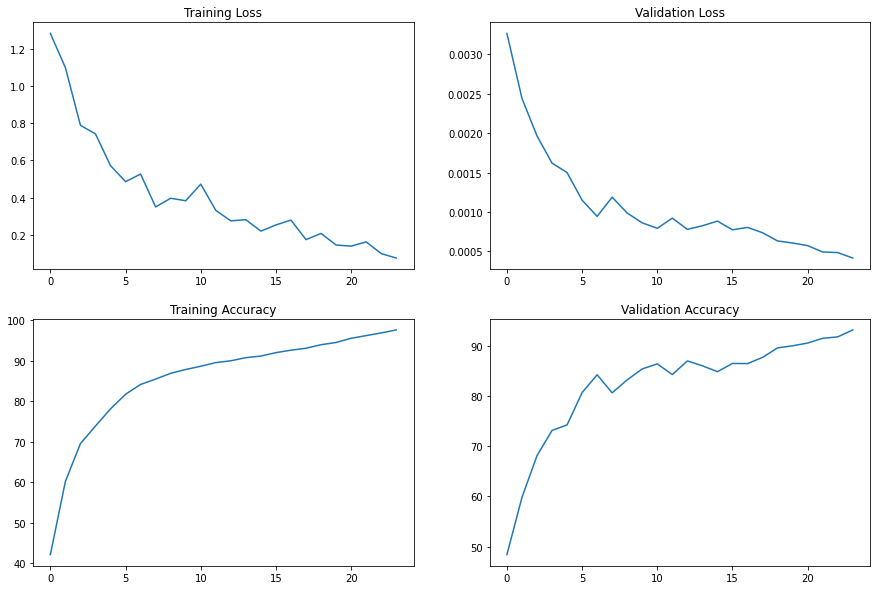

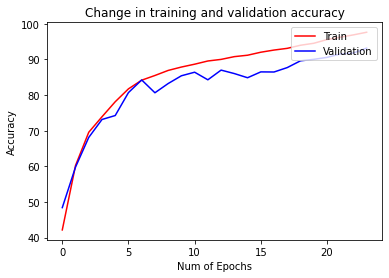

In [18]:
# train_obj.plot_cycle_lr()
Plot.plot_cycle_lr(25,train_obj.train_lr)
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_graph()


###Display 25 misclassified images

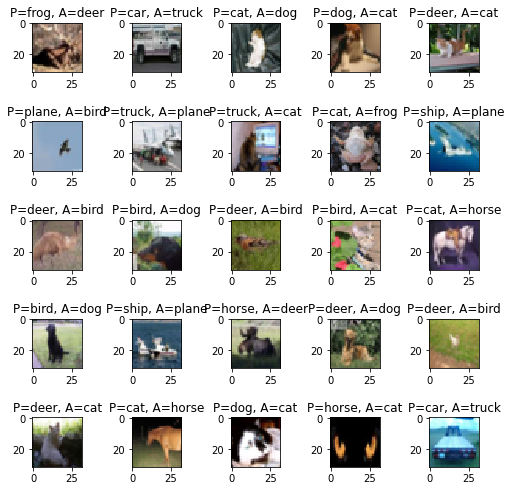

In [19]:
plt_obj.plot_cifar_misclassified(misclassified_images)

###Visualizing Gradcam results for 25 misclassified images in all layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


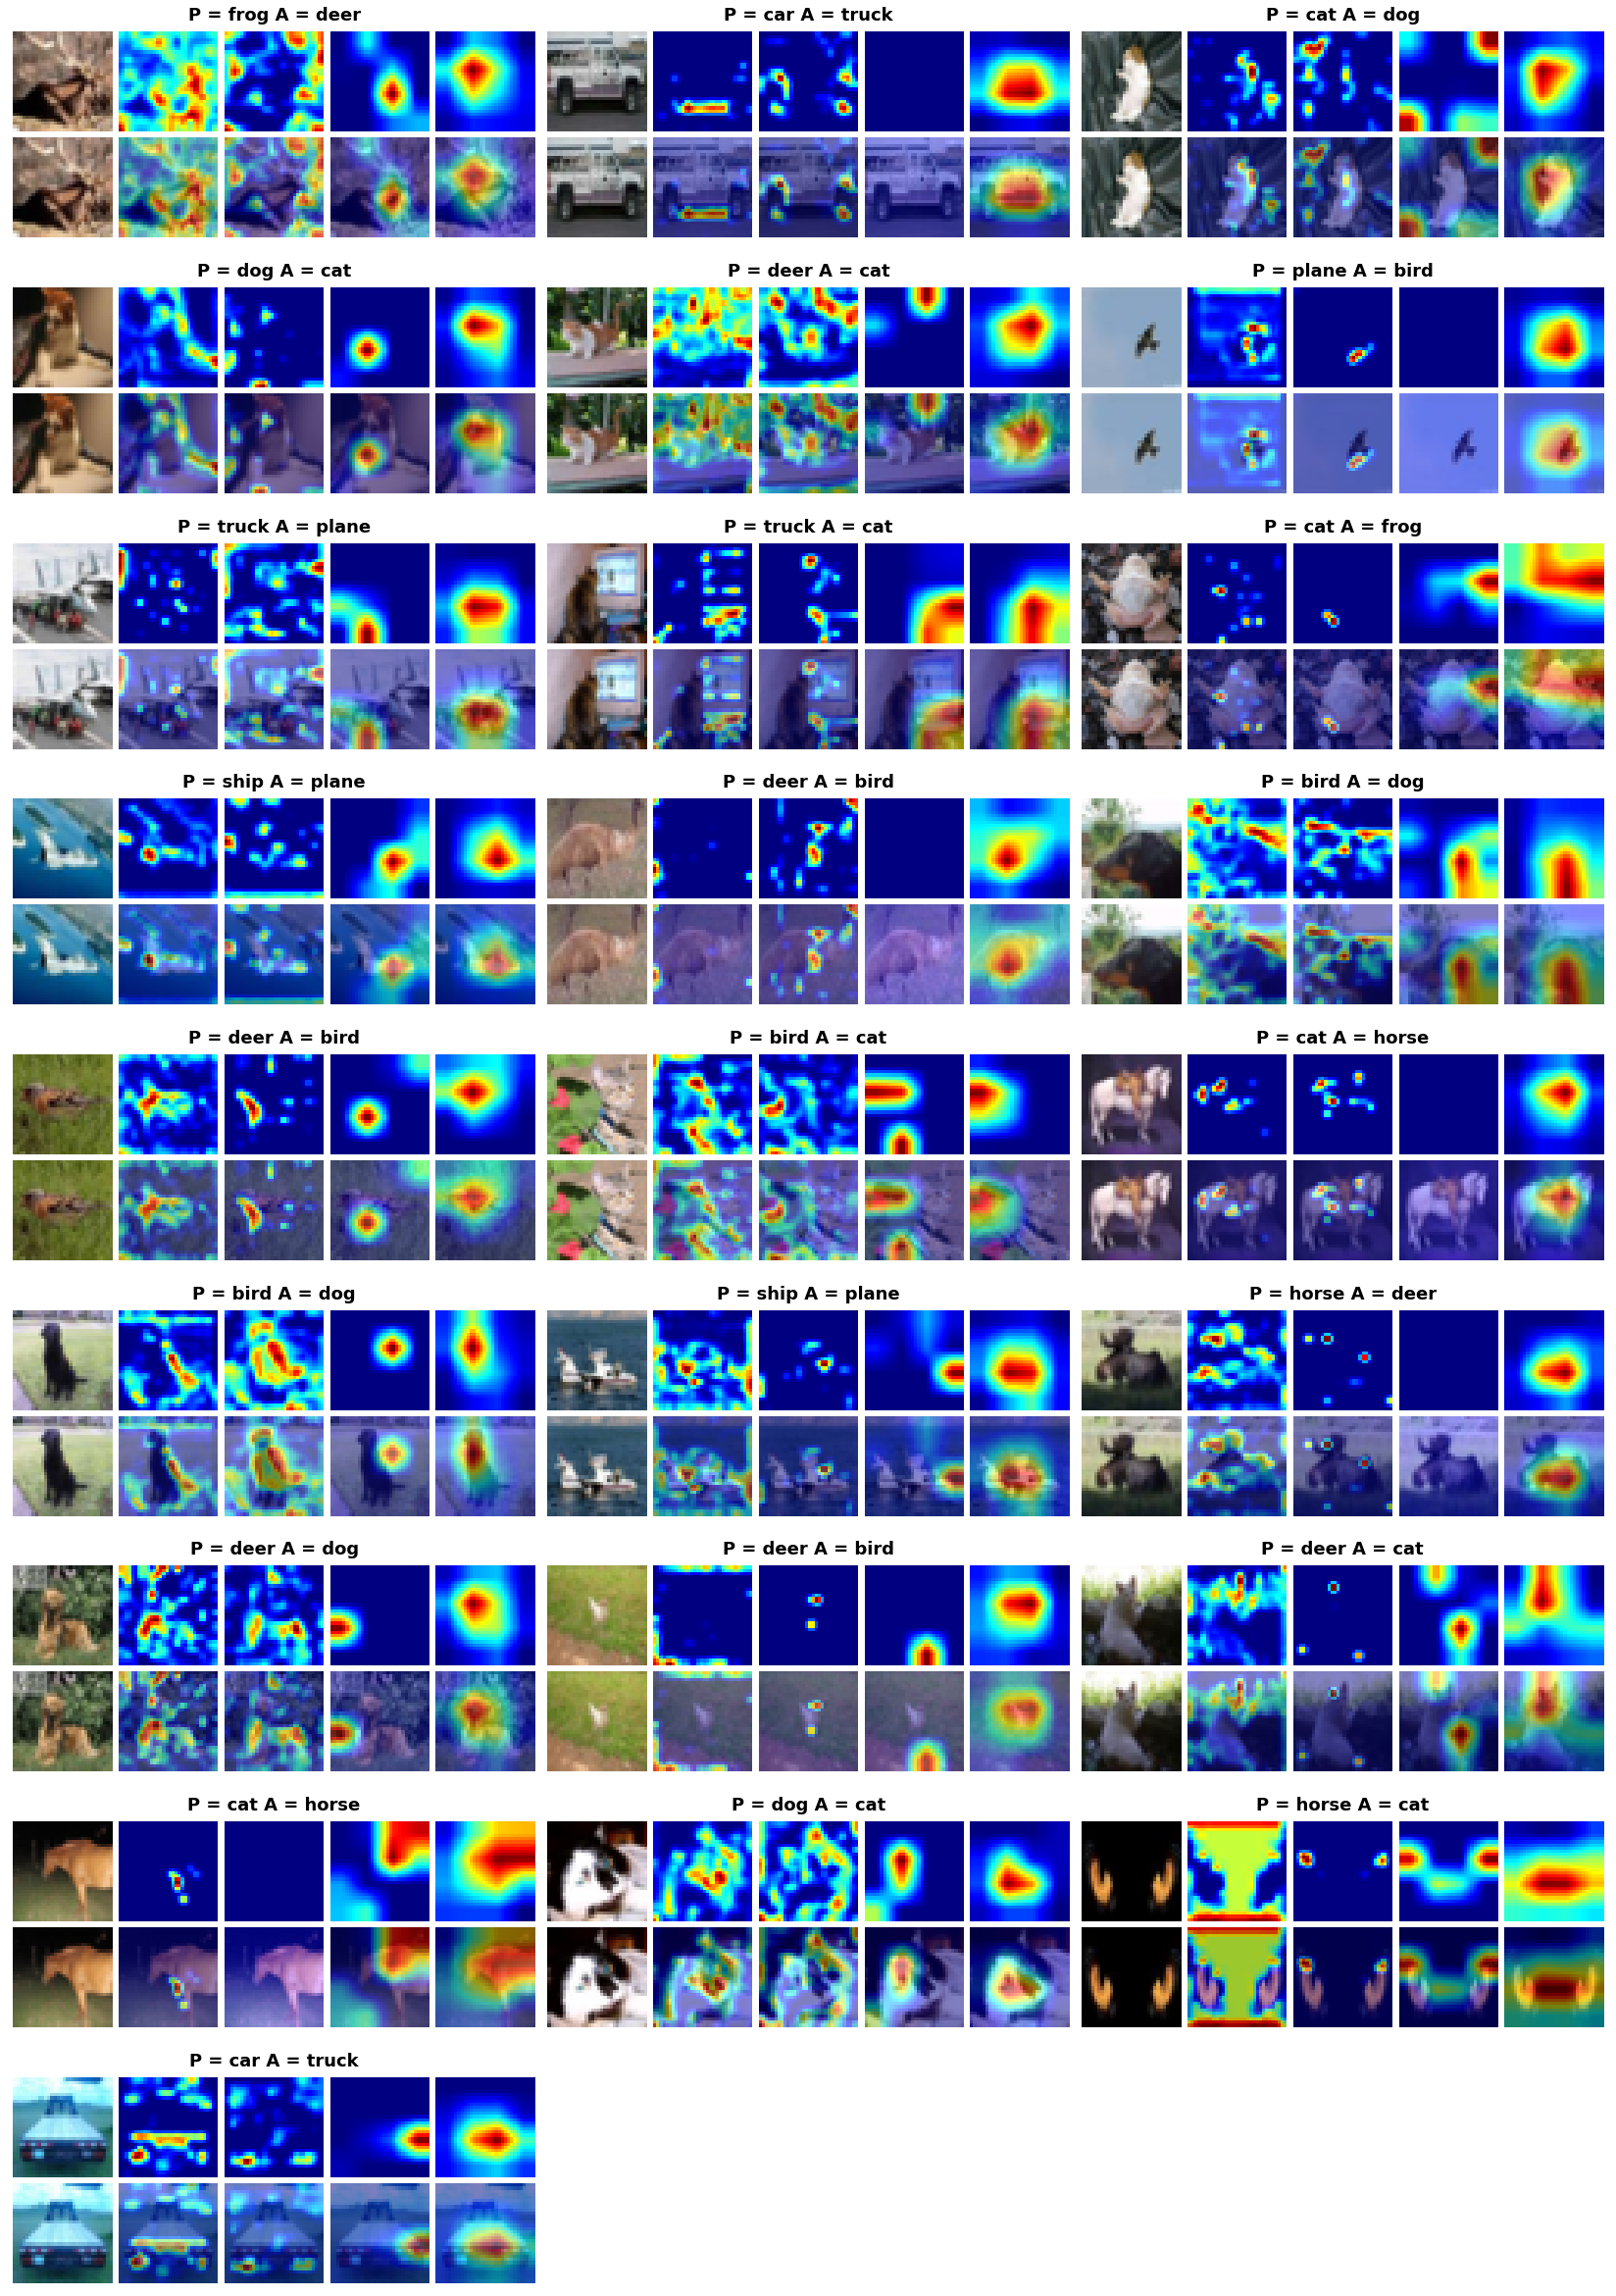

In [20]:
layers = [model.layer1, model.R1, model.layer3, model.R2]
helper_obj.get_gradcam_images(model,layers,misclassified_images,classes)